In [1]:
import matplotlib
import matplotlib.pyplot as plt

import numpy as np
import os

from skimage.io import imread, imsave

from keras import applications
from keras import optimizers
from keras.models import Sequential, Model
from keras.layers import Activation, Dense, Dropout, Flatten, GlobalAveragePooling2D
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

from sklearn.metrics import fbeta_score, precision_score
from sklearn.model_selection import train_test_split
import pandas as pd
import cv2

%matplotlib inline

/home/csci8523/ganta016/.local/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
source_dir = os.path.join('train-tif-v2')

In [3]:
x_train = []
y_train = []

train_data = pd.read_csv('train_v2.csv/train_v2.csv')

label_enum = 0
label_map = {}
labels = {}
for tags in train_data['tags']:
    classes = tags.split(" ")
    for label in classes:
        if label not in label_map:
            label_map[label] = label_enum
            labels[label_enum] = label
            label_enum = label_enum + 1
    if label_enum == 17:
        break
i = 0
for image, tags in train_data.values:
    i = i+1
    if i%1000==0:
        print(i, image)
    image_path = source_dir+"/"+image+".tif"
    img = cv2.imread(image_path)
    img = cv2.resize(img, (139, 139))
    one_hot_labels = np.zeros(len(label_map))
    for label in tags.split(' '):
        one_hot_labels[label_map[label]] = 1
    x_train.append(img/255.0)
    y_train.append(one_hot_labels)
    
y_train = np.array(y_train, np.uint8)
x_train = np.array(x_train, np.float32)

print(x_train.shape)
print(y_train.shape)

1000 train_999
2000 train_1999
3000 train_2999
4000 train_3999
5000 train_4999
6000 train_5999
7000 train_6999
8000 train_7999
9000 train_8999
10000 train_9999
11000 train_10999
12000 train_11999
13000 train_12999
14000 train_13999
15000 train_14999
16000 train_15999
17000 train_16999
18000 train_17999
19000 train_18999
20000 train_19999
21000 train_20999
22000 train_21999
23000 train_22999
24000 train_23999
25000 train_24999
26000 train_25999
27000 train_26999
28000 train_27999
29000 train_28999
30000 train_29999
31000 train_30999
32000 train_31999
33000 train_32999
34000 train_33999
35000 train_34999
36000 train_35999
37000 train_36999
38000 train_37999
39000 train_38999
40000 train_39999
(40479, 139, 139, 3)
(40479, 17)


In [4]:
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size =0.2)
x_test, x_val, y_test, y_val = train_test_split(x_val, y_val, test_size =0.5)

In [5]:
pretrained_model = applications.InceptionV3(include_top=False, weights='imagenet', input_shape = (139, 139, 3))
pretrained_model.trainable = False

In [6]:
input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)

In [7]:
optimizer = Adam()
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
253/253 - 116s - loss: 0.1846 - accuracy: 0.8034 - val_loss: 0.1625 - val_accuracy: 0.8419 - 116s/epoch - 458ms/step
Epoch 2/10
253/253 - 104s - loss: 0.1595 - accuracy: 0.8212 - val_loss: 0.1565 - val_accuracy: 0.8434 - 104s/epoch - 413ms/step
Epoch 3/10
253/253 - 108s - loss: 0.1531 - accuracy: 0.8182 - val_loss: 0.1545 - val_accuracy: 0.8360 - 108s/epoch - 429ms/step
Epoch 4/10
253/253 - 108s - loss: 0.1490 - accuracy: 0.8149 - val_loss: 0.1529 - val_accuracy: 0.8204 - 108s/epoch - 428ms/step
Epoch 5/10
253/253 - 106s - loss: 0.1458 - accuracy: 0.8092 - val_loss: 0.1523 - val_accuracy: 0.8098 - 106s/epoch - 418ms/step
Epoch 6/10
253/253 - 103s - loss: 0.1426 - accuracy: 0.8016 - val_loss: 0.1529 - val_accuracy: 0.8083 - 103s/epoch - 409ms/step
Epoch 7/10
253/253 - 95s - loss: 0.1395 - accuracy: 0.8050 - val_loss: 0.1543 - val_accuracy: 0.8036 - 95s/epoch - 374ms/step
Epoch 8/10
253/253 - 79s - loss: 0.1366 - accuracy: 0.7994 - val_loss: 0.1556 - val_accuracy: 0.7512 - 79s

In [8]:
model.save_weights("model_tif_pre_final_1.h5")

In [9]:
for layer in pretrained_model.layers[:176]:
   layer.trainable = False
for layer in pretrained_model.layers[176:]:
   layer.trainable = True

input_layer = pretrained_model.input
model_output = pretrained_model.output
pooling_layer = GlobalAveragePooling2D()(model_output)
dense_layer = Dense(2048, activation='relu')(pooling_layer)
dropout_layer = Dropout(0.5)(dense_layer)
output_layer = Dense(17, activation='sigmoid')(dropout_layer)
model = Model(inputs=input_layer, outputs=output_layer)
model.load_weights("model_tif_pre_final.h5")

adam = Adam()
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

Epoch 1/10
253/253 - 214s - loss: 0.2074 - accuracy: 0.8021 - val_loss: 0.2777 - val_accuracy: 0.2085 - 214s/epoch - 846ms/step
Epoch 2/10
253/253 - 198s - loss: 0.1503 - accuracy: 0.8074 - val_loss: 0.2446 - val_accuracy: 0.8209 - 198s/epoch - 783ms/step
Epoch 3/10
253/253 - 202s - loss: 0.1423 - accuracy: 0.8021 - val_loss: 0.2300 - val_accuracy: 0.7394 - 202s/epoch - 799ms/step
Epoch 4/10
253/253 - 197s - loss: 0.1372 - accuracy: 0.7986 - val_loss: 0.2365 - val_accuracy: 0.7769 - 197s/epoch - 780ms/step
Epoch 5/10
253/253 - 189s - loss: 0.1326 - accuracy: 0.7993 - val_loss: 0.1746 - val_accuracy: 0.6966 - 189s/epoch - 745ms/step
Epoch 6/10
253/253 - 192s - loss: 0.1298 - accuracy: 0.7932 - val_loss: 0.5426 - val_accuracy: 0.2720 - 192s/epoch - 758ms/step
Epoch 7/10
253/253 - 206s - loss: 0.1277 - accuracy: 0.7896 - val_loss: 0.2155 - val_accuracy: 0.5697 - 206s/epoch - 814ms/step
Epoch 8/10
253/253 - 201s - loss: 0.1249 - accuracy: 0.7871 - val_loss: 0.1749 - val_accuracy: 0.7989 - 

In [10]:
model.save_weights('model_tif_final_21.h5')

In [11]:
adam = Adam(lr = 0.0005)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size=128,verbose=2, epochs=10, shuffle=True)

/home/csci8523/ganta016/.local/lib/python3.8/site-packages/keras/optimizers/optimizer_v2/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
253/253 - 195s - loss: 0.1179 - accuracy: 0.7794 - val_loss: 0.2219 - val_accuracy: 0.7594 - 195s/epoch - 769ms/step
Epoch 2/10
253/253 - 199s - loss: 0.1139 - accuracy: 0.7740 - val_loss: 1.2003 - val_accuracy: 0.6991 - 199s/epoch - 785ms/step
Epoch 3/10
253/253 - 199s - loss: 0.1106 - accuracy: 0.7672 - val_loss: 0.4965 - val_accuracy: 0.4827 - 199s/epoch - 787ms/step
Epoch 4/10
253/253 - 190s - loss: 0.1081 - accuracy: 0.7559 - val_loss: 0.6753 - val_accuracy: 0.2315 - 190s/epoch - 749ms/step
Epoch 5/10
253/253 - 183s - loss: 0.1041 - accuracy: 0.7507 - val_loss: 0.1700 - val_accuracy: 0.6996 - 183s/epoch - 724ms/step
Epoch 6/10
253/253 - 191s - loss: 0.1009 - accuracy: 0.7473 - val_loss: 0.1981 - val_accuracy: 0.7725 - 191s/epoch - 754ms/step
Epoch 7/10
253/253 - 201s - loss: 0.0966 - accuracy: 0.7445 - val_loss: 0.2725 - val_accuracy: 0.4511 - 201s/epoch - 796ms/step
Epoch 8/10
253/253 - 199s - loss: 0.0925 - accuracy: 0.7211 - val_loss: 0.2912 - val_accuracy: 0.6831 - 

In [12]:
model.save_weights('model_tif_final_22.h5')

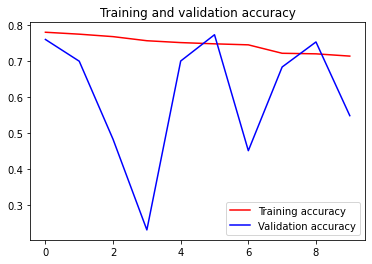

<Figure size 432x288 with 0 Axes>

In [13]:
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(train_accuracy))

plt.plot(epochs, train_accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

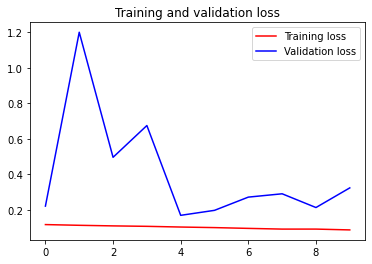

<Figure size 432x288 with 0 Axes>

In [14]:
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [15]:
y_pred = model.predict(x_test, batch_size = 128, verbose=2)

32/32 - 10s - 10s/epoch - 301ms/step


In [16]:
f2_score = fbeta_score(y_test, np.array(y_pred)>0.2, beta=2, average='samples')
print("F2 score:",f2_score)

F2 score: 0.7566997680292473


In [17]:
y_pred = np.array(y_pred)>0.2
total = np.sum(y_test,axis = 0)
tp = np.sum(y_test*y_pred,axis=0)
tn = np.sum((1-y_test)*(1-y_pred),axis=0)
fp = np.sum((1-y_test)*y_pred,axis=0)
fn = np.sum(y_test*(1-y_pred),axis=0)

d = {'Total':total,'TP':tp,'TN':tn,'FP':fp,'FN':fn}
pd.DataFrame(d, index=label_map)


,Total,TP,TN,FP,FN
haze,282,4,3749,17,278
primary,3763,3757,14,271,6
agriculture,1196,1082,1891,961,114
clear,2823,2798,591,634,25
water,737,562,1133,2178,175
habitation,357,269,3124,567,88
road,757,715,397,2894,42
cultivation,451,79,3473,124,372
slash_burn,24,0,4024,0,24
cloudy,199,26,3836,13,173


In [18]:
sum = np.add(tp, fp)
precision = np.divide(tp, sum)
recall = np.divide(tp, np.add(tp, fn))
accuracy = np.divide(np.add(tp, tn), np.add(fp, np.add(fn, np.add(tp, tn))))
f1 = 2*(np.divide(np.multiply(precision, recall), np.add(precision, recall)))
f2 = (np.divide(5*np.multiply(precision, recall), np.add(4*precision, recall)))
evalution_metrics = {'Accuracy':accuracy,'Precision':precision,'Recall':recall,'f1':f1, 'f2': f2}
pd.DataFrame(evalution_metrics, index=label_map)

<ipython-input-18-bd4fa39ebb4b>:2: RuntimeWarning: invalid value encountered in divide
  precision = np.divide(tp, sum)


,Accuracy,Precision,Recall,f1,f2
haze,0.927125,0.190476,0.014184,0.026403,0.017406
primary,0.931571,0.932721,0.998406,0.964446,0.984539
agriculture,0.734437,0.529613,0.904682,0.668107,0.792442
clear,0.837204,0.815268,0.991144,0.894644,0.950149
water,0.418725,0.205109,0.762551,0.323267,0.494023
habitation,0.838192,0.321770,0.753501,0.450964,0.594081
road,0.274704,0.198116,0.944518,0.327531,0.538647
cultivation,0.877470,0.389163,0.175166,0.241590,0.196811
slash_burn,0.994071,NaN,0.000000,NaN,NaN
cloudy,0.954051,0.666667,0.130653,0.218487,0.155689


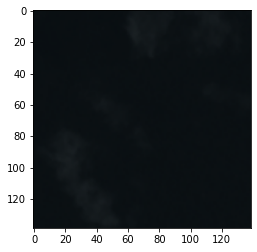

1/1 - 1s - 558ms/epoch - 558ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


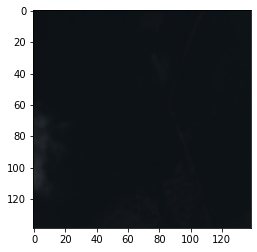

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True  True False  True False  True False False False  True  True
 False False False False False]
True label
primary agriculture road cultivation partly_cloudy 
Predicted
primary agriculture water road partly_cloudy conventional_mine 


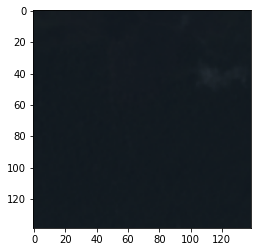

1/1 - 0s - 36ms/epoch - 36ms/step
[False  True  True False False False  True False False False  True False
 False False False False False]
True label
primary slash_burn partly_cloudy 
Predicted
primary agriculture road partly_cloudy 


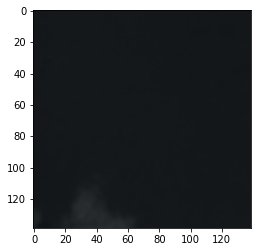

1/1 - 0s - 36ms/epoch - 36ms/step
[False  True  True False False False  True False False False  True False
 False False False False False]
True label
agriculture partly_cloudy 
Predicted
primary agriculture road partly_cloudy 


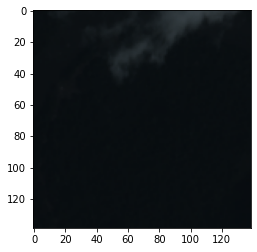

1/1 - 0s - 36ms/epoch - 36ms/step
[False  True  True False  True False False False False False  True False
 False False False False False]
True label
primary water road partly_cloudy 
Predicted
primary agriculture water partly_cloudy 


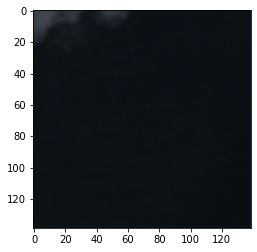

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True False False  True False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary water partly_cloudy 


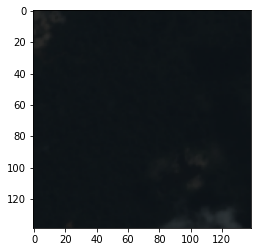

1/1 - 0s - 39ms/epoch - 39ms/step
[False  True  True  True False False  True False False False  True False
 False False False False False]
True label
primary water partly_cloudy artisinal_mine 
Predicted
primary agriculture clear road partly_cloudy 


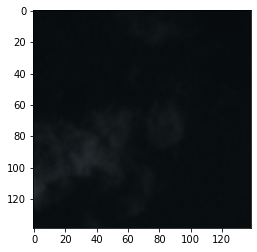

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture partly_cloudy 


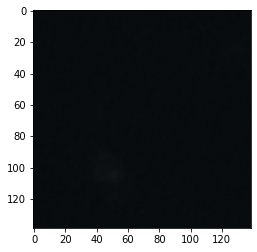

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True  True False False False  True False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture road partly_cloudy 


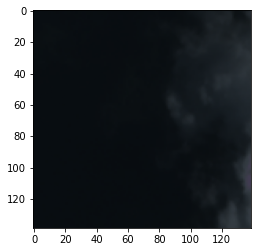

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary partly_cloudy 


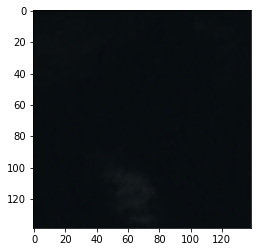

1/1 - 0s - 35ms/epoch - 35ms/step
[False  True  True  True False False  True False False False  True False
 False False False False False]
True label
primary agriculture partly_cloudy 
Predicted
primary agriculture clear road partly_cloudy 


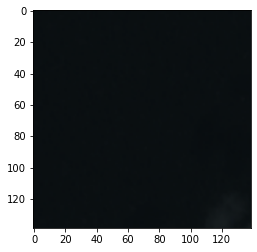

1/1 - 0s - 34ms/epoch - 34ms/step
[False  True  True False  True False  True False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture water road partly_cloudy 


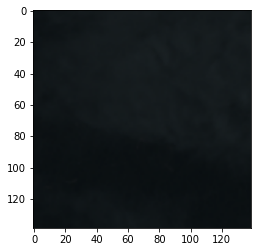

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False  True False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture water partly_cloudy 


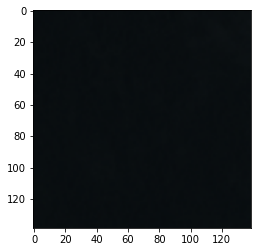

1/1 - 0s - 32ms/epoch - 32ms/step
[False  True  True  True  True  True  True False False False False False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture clear water habitation road 


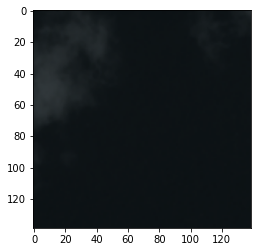

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture partly_cloudy 


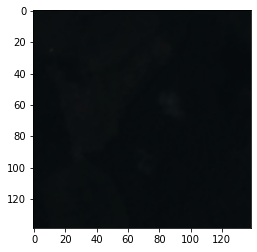

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True False False False  True  True False False  True False
 False False False False False]
True label
primary agriculture cultivation partly_cloudy 
Predicted
primary agriculture road cultivation partly_cloudy 


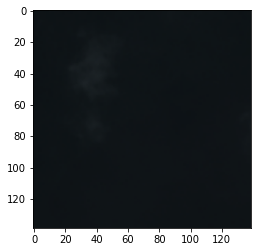

1/1 - 0s - 33ms/epoch - 33ms/step
[False  True  True False False False False False False False  True False
 False False False False False]
True label
primary water partly_cloudy 
Predicted
primary agriculture partly_cloudy 


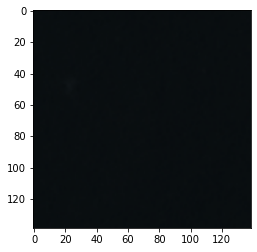

1/1 - 0s - 31ms/epoch - 31ms/step
[False  True  True  True  True  True  True False False False False False
 False False False False False]
True label
primary partly_cloudy 
Predicted
primary agriculture clear water habitation road 


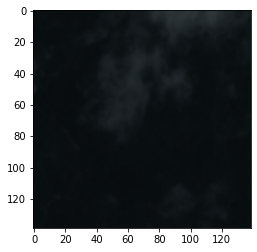

1/1 - 0s - 30ms/epoch - 30ms/step
[False  True False False False False False False False False  True False
 False False False False False]
True label
primary road partly_cloudy 
Predicted
primary partly_cloudy 


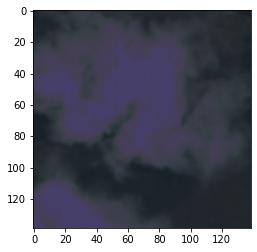

1/1 - 0s - 31ms/epoch - 31ms/step
[False False False False False False False False False  True False False
 False False False False False]
True label
primary agriculture road partly_cloudy 
Predicted
cloudy 


In [19]:
j = 0
k=0
while(j<20 and k<len(x_test)):
    img = x_test[k]
    tags = ''
    y = y_test[k]
    cloudy = False
    for i in range(len(y)):
        if y[i] == 1:
            tags = tags + labels[i] + ' '
            if labels[i] == 'partly_cloudy':
                cloudy = True
    if cloudy:
        plt.imshow(img)
        plt.show()
        img = np.expand_dims(img, axis = 0)
        y = model.predict(img, batch_size = 1, verbose=2)
        y_pred = np.array(y > 0.2).reshape(-1)
        print(y_pred)
        preds = ""
        for i in range(len(y_pred)):
            if y_pred[i] != 0:
                preds = preds+labels[i]+" "
        print('True label')
        print(tags)
        print('Predicted')
        print(preds)
        j+=1
    k=k+1